In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [154]:
from scipy.integrate import quad

# ground state energy (equation 9)
# returns u, d_u/d_rho
def ue(rho, model='PBE'):
    
    if model == 'PBE':
        
        a = [78.0913, -172.712, 18.095, -0.717051, 130.541, 67.2915]
        
    elif model == 'HSE':
        
        a = [-16.8923, -85.0197, 8.33865, -0.150425, 59.9442, 38.2224]
        
    elif model == 'vdW':
        
        a = [84.7263, -175.063, 18.6251, -0.757606, 131.406, 66.7509]
        
    elif model == 'AM05':
        
        a = [137.924, -217.067, 22.4402, -0.943835, 166.409, 82.6152]
        
    elif model == 'LDA':
        
        a = [134.099, -240.338, 25.5167, -1.13834, 182.303, 88.3112]
        
    x = [1, rho, rho**2, rho**3, np.log(rho), np.log(rho)**2]
    dx = [0, 1, 2 * rho, 3 * rho**2, 1/rho, 2 * np.log(rho) / rho]
    
    return np.dot(a, x), np.dot(a, dx)

ue = np.vectorize(ue)

def debye(z):
    
    return (3 / z**3) * quad(lambda x: x**3 / (np.exp(x) - 1), 0, z)[0]

debye = np.vectorize(debye)

# thermal part of free energy (equation 11)
# returns f, d_f/d_rho, s = -d_f/d_T
def ft(rho, T):
    
    alpha = [6.869192e-3, -3.919234e-3, 6.790631e-5]
    gamma = [
        [-2.604037e-2, 2.104060e-2, -1.515928e-3], 
        [6.721305e-2, -1.158057e-1, 5.234025e-2], 
        [-1.178112e-1, 1.754266e-1, -6.213482e-2], 
        [1.206828e-1, -1.910820e-1, 7.712887e-2]
    ]
    
    TD = 700
    TE = 1000
    Tj = TE * np.array([1, 2, 4, 8])
    Tj = np.tile(Tj, (3, 1)).T

    k = np.array([-4, -3, -2])
    x = T * (3 * np.log(1 - np.exp(-TD/T)) - debye(TD/T))
    f = x * np.dot(alpha, rho**(k/3))
    f_rho = x * np.dot(alpha, (k/3) * rho**(k/3 - 1))
    s = (4 * debye(TD/T) - 3 * np.log(1 - np.exp(-TD/T))) * np.dot(alpha, rho**(k/3))
        
    k = np.tile(k, (4, 1))
    f += np.sum(gamma * rho**(k / 3) * T * np.log(1 - np.exp(-Tj / T)))
    f_rho += np.sum(gamma * (k/3) * rho**(k/3 - 1) * T * np.log(1 - np.exp(-Tj / T)))
    s += np.sum(gamma * rho**(k / 3) * ((Tj / T) / (np.exp(Tj / T) - 1) - np.log(1 - np.exp(-Tj/T))))

    return f, f_rho, s

ft = np.vectorize(ft)

# nuclear ground-state energy (equation 15)
# returns un, d_un/d_rho
def un(rho):
    
    b = [2.08, 0.272, 0.096, 0.788]
    
    x = np.dot(b, [1, rho, rho**2, np.exp(-2.54e-5 * rho**10)])
    dx = np.dot(b, [0, 1, 2 * rho, -2.54e-4 * np.exp(-2.54e-5 * rho**10) * (rho**9)])
    
    return x, dx

un = np.vectorize(un)

# implements the French EoS 
# returns free energy, entropy, pressure, internal energy
def french(rho, T, model='PBE'):
    
    ue_ = ue(rho, model)
    un_ = un(rho)
    ft_ = ft(rho, T)
    
    f = ue_[0] + un_[0] + ft_[0]
    s = ft_[2]
    p = rho * rho * (ue_[1] + un_[1] + ft_[1])
    u = -T * T * (-s / T + f * np.log(T))
    
    return f, s, p, u

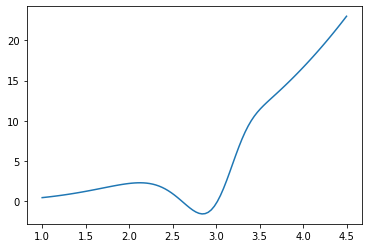

In [146]:
rho = np.linspace(1, 4.5, 100)
plt.plot(rho, rho * rho * un(rho)[1])

(0.0, 4.0)

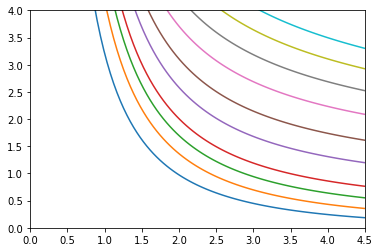

In [139]:
rho = np.linspace(0.1, 4.5, 100)
T = [295, 400, 500, 600, 800, 1000, 1250, 1500, 1750, 2000]

for T in T:
    s = ft(rho, T)[1] * 18000 / (6.022 * 1.38 * 3)
    plt.plot(rho, s)
    
plt.xlim(0, 4.5)
plt.ylim(0, 4)

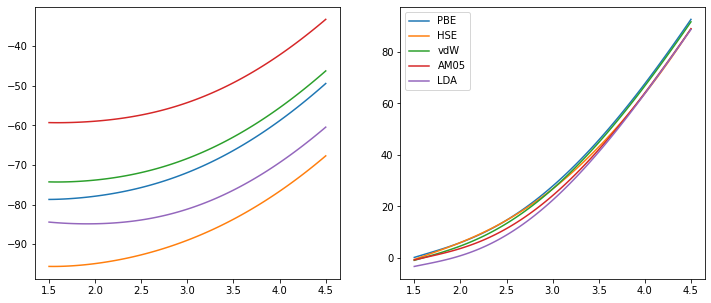

In [13]:
rho = np.linspace(1.5, 4.5, 100)

models = ['PBE', 'HSE', 'vdW', 'AM05', 'LDA']

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for m in models:
    axs[0].plot(rho, ue(rho, model=m)[0], label=m)
    
for m in models:
    axs[1].plot(rho, rho * ue(rho, model=m)[1], label=m)
    
plt.legend()

(1.5, 3.75)

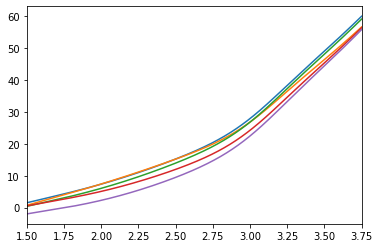

In [164]:
rho = np.linspace(1.5, 3.75, 1000)

for m in models:
    p_reduced = french(rho, 295, model=m)[2] / rho
    plt.plot(rho, p_reduced)
    
plt.xlim(1.5, 3.75)